In [1]:
!pip install matplotlib-venn

In [2]:
from keras.datasets import fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
labels=["T-shirt/top","Trouser","Pullover","Dress","Coat",
        "Sandal","Shirt","Sneaker","Bag","Ankle boot"]

4423680/4422102 [==============================] - 0s 0us/step


Question 1: Download the fashion-MNIST dataset and plot 1 sample image for each class as shown in the grid below. Use "from keras.datasets import fashion_mnist" for getting the fashion mnist dataset.

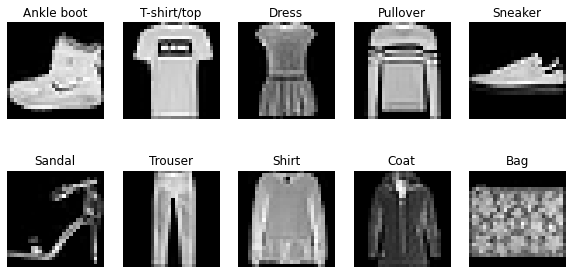

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5)) 

plottedClass =  [False for i in range(10)] 
count=0
for i in range(25):
    if  plottedClass[y_train[i]]==False:
      plt.subplot(2,5,count+1).set_title(labels[y_train[i]]) 
      plt.imshow(X_train[i],cmap='gray')
      plt.axis("off")
      plottedClass[y_train[i]]=True
      count=count+1

plt.show()

Question2:Implement a feedforward neural network which takes images from the fashion-mnist data as input and outputs a probability distribution over the 10 classes.

Your code should be flexible so that it is easy to change the number of hidden layers and the number of neurons in each hidden layer.

We will check the code for implementation and ease of use.

